In [1]:
import json
import numpy as np
from skimage import io
from scipy import signal

In [2]:
from matplotlib import pyplot as plt 
%matplotlib inline

In [3]:
from urllib.request import urlopen
from urllib.error import URLError
def ping(url):
    try:
        urlopen(url)
        return True         # URL Exist
    except (ValueError):
        return False        # URL not well formatted
    except (URLError):
        return False        # URL don't seem to be alive

In [4]:
cd ..

/home/val/MEGA/eScienceWork/projects/OOIVideos


In [5]:
# generate a list of movie urls
import src
from src.generate_urls import generate_urls
list_urls = generate_urls('2016/05/01','2016/06/30','DAILY',2)
list_movie_urls = [url[:-11] for url in list_urls]
filtered_urls = [url for url in list_movie_urls if ping(url)] 

In [6]:
def calculateRollingStats_list(filename, lag=3, subsampleRate=10, frame_start=0, frame_end=-1):
    
    from skimage import io
    import numpy as np
    import json
    from urllib.request import urlopen
    
    try:
        response = urlopen(filename)
    except:
        return('a')
    # extracting the video dimensions
    header = json.loads(response.read().decode())
    nofFrames = header['NumFrames']
    


    if frame_end == -1:
        frame_end = nofFrames

    # generate the list of frame numbers we will process
    nums = list(np.arange(frame_start,frame_end,subsampleRate))

    list_urls = [filename+'/frame/'+str(num) for num in nums]
    
    # initializing return variables
    rolling_mean = []
    rolling_var = []


    # process first block
    block = []
    for i in np.arange(lag):
        try:
            image = io.imread(list_urls[i])[:,:,0]
        except:
            return(None)
        block.append(image)
        
    block_array = np.array(block)
    rolling_var.append(np.sum(np.var(block_array,0)))

    
    # process all other blogs

    for i in np.arange(lag,len(nums)):
        try:
            image = io.imread(list_urls[i])[:,:,0]
        except:
            return(None)
        
        block.append(image)
        block.pop(0)
        block_array = np.array(block)

        rolling_var.append(np.sum(np.var(block_array,0)))


    return(rolling_var)

In [7]:
subsampleRate = 10

In [8]:
# This step takes a lot of time: do not run it! Use pickled results instead.
# %time res = [calculateRollingStats_list(url,lag=3,subsampleRate=10,frame_start=3000,frame_end=7000) for url in filtered_urls]

In [9]:
# res_np = [np.array(r) for r in res]

In [10]:
import pickle

In [11]:
# save result
# with open('res.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump(res_np, f)

In [12]:
# with open('res_np.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump(res_np, f)

### Start HERE to use pickled time series

In [13]:
with open('res_np.pickle', 'rb') as f:  
    res_np = pickle.load(f)

In [14]:
# with open('urls.pickle', 'rb') as f:  
#    filtered_urls = pickle.load(f)

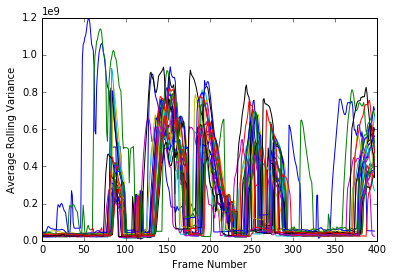

In [15]:
[plt.plot(ts) for ts in res_np]
plt.ylabel('Average Rolling Variance')
plt.xlabel('Frame Number')
# plt.xticks(range(3000,400*10+3000,100))

In [16]:
# function to determine offset for alignment
def sync_corr(signal1, signal2):
    l = len(signal1)
    cc = signal.fftconvolve(np.abs(signal1),np.abs(signal2[::-1]), mode='full')
    # finding the maximum correlation
    offset = cc.argmax() + l - len(cc)
    return(offset)

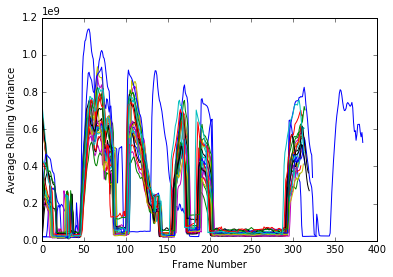

In [17]:
# align all time series
offsets = []
for i in range(1,len(res_np)):
    if res_np[i].shape != ():
        offset = sync_corr(res_np[0],res_np[i])
        offsets.append(offset)
        plt.plot(res_np[i][-offset:])
    else: 
        offsets.append(None)
plt.ylabel('Average Rolling Variance')
plt.xlabel('Frame Number')

In [18]:
# first offset is zero
offsets = [0]+offsets

In [20]:
aligned_urls = [url+'/frame/'+str(150*subsampleRate+3000-offset*subsampleRate) for url,offset in zip(filtered_urls,offsets) if offset is not None]

In [21]:
aligned_urls[0]

'https://lazycache-dot-ferrous-ranger-158304.appspot.com/v1/org/oceanobservatories/rawdata/files/RS03ASHS/PN03B/06-CAMHDA301/2016/05/01/CAMHDA301-20160501T000000Z.mov/frame/4500'

### Create the aligned time lapse

In [22]:
video_timelapse = []
for url in aligned_urls:
    try:
        video_timelapse.append(io.imread(url))
    except:
        print(url)

### Writing the frames to a movie

In [24]:
import imageio

In [25]:
writer = imageio.get_writer('timelapse.mp4', fps=1)

for im in video_timelapse:
    writer.append_data(im)
writer.close()